In [6]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import json
import numpy as np
import sys
import importlib
import shutil
import math
import os
from pathlib import Path
import warnings

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation


warnings.simplefilter('ignore')

MIN_THRESHOLD = -10000000

%matplotlib inline

# First data point is the claimed performance of the model

- need to plot FROCs for GRT123 and Detection trained and evaluated on LUNA

NOTE 1: Operating points are provided by Detection so these will not be derived from data

NOTE 2: The FROC for GRT123 was never clearly published a rough guide to what was expected was shown but this included additional training from the Kaggle dataset


/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/luna_5_folds/metadata.csv
Total number of included nodule annotations: 146
Total number of nodule annotations: 1034
Cases: 889
noduleAnnots: [<evaluation.NoduleFinding object at 0x7f3cab2239a0>]
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/10

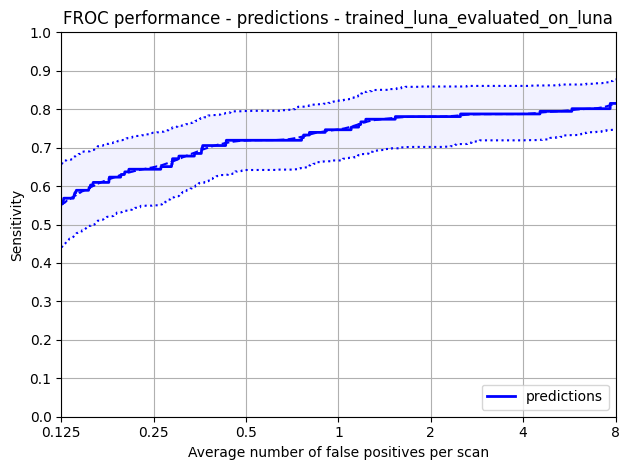

In [14]:
import pandas as pd
from pathlib import Path

cwd = '/home/jmccabe/SOTAEvaluationNoduleDetection'

def get_annotations_path(original_annotations_path, output_path):
    annotations = pd.read_csv(original_annotations_path).rename(columns={
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
    })
    annotations.to_csv(Path(output_path , 'annotations.csv'))
    return Path(output_path, 'annotations.csv')

def get_exclusions_path(original_exclusions_path, output_path):
    exclusions = pd.read_csv(original_exclusions_path).rename(columns={
        'seriesuid' : 'name',
        'coordX' : 'row',
        'coordY' : 'col',
        'coordZ' : 'index',
        'diameter_mm' : 'diameter'
    })

    exclusions.to_csv(Path(output_path , 'exclusions.csv'))
    return Path(output_path, 'exclusions.csv')

annotations_exclude_filepath = get_exclusions_path(
                                Path(cwd, 'scans/Luna16/annotations_excluded.csv'),
                                Path(cwd, 'models/grt123/bbox_result/luna_5_folds')
                            )

scanlist_filepath = Path(cwd, 'output/metadata/luna/test_fold1_scans.csv')

annotations_filepath = Path(cwd, 'models/grt123/bbox_result/luna_5_folds/metadata.csv')
predictions_filepath = Path(cwd, 'models/grt123/bbox_result/luna_5_folds/predictions.csv')

results_dir = Path(cwd, 'output/results/grt123/trained_luna/luna_5_folds')
results_dir.mkdir(parents=True, exist_ok=True)


fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename='/home/jmccabe/SOTAEvaluationNoduleDetection/scans/Luna16/pixel_exclusions.csv',
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,
    outputDir=results_dir,
    filter='trained_luna_evaluated_on_luna',
)

/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/summit/metadata.csv


Total number of included nodule annotations: 766
Total number of nodule annotations: 766
Cases: 596
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1000
computing FROC: bootstrap 23/1000
computing FROC: bootstrap 24/1000
computing FROC: bootstrap 25/1000
computing FROC: bootstrap 

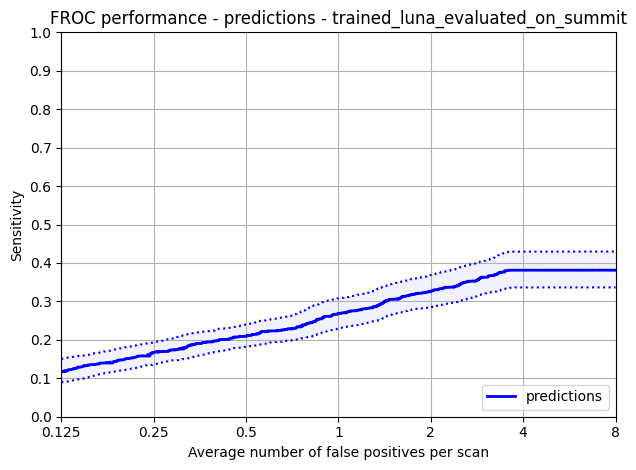

In [18]:
cwd = '/home/jmccabe/SOTAEvaluationNoduleDetection'

scanlist_filepath = Path(cwd, 'output/metadata/reduced/test_scans.csv')

annotations_filepath = Path(cwd, 'models/grt123/bbox_result/summit/metadata.csv')
predictions_filepath = Path(cwd, 'models/grt123/bbox_result/summit/predictions.csv')
annotations_exclude_filepath = Path(cwd, 'models/grt123/bbox_result/summit/exclusions.csv')

results_dir = Path(cwd, 'output/results/grt123/trained_luna/summit')
results_dir.mkdir(parents=True, exist_ok=True)


fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=annotations_exclude_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,
    outputDir=results_dir,
    filter='trained_luna_evaluated_on_summit',
)

# Detection



Set up fns to convert the detect output ... json format into predictions.csv file

In [23]:
from importlib import metadata
from math import e
import pandas as pd
from pathlib import Path

LUNA_EXCLUSIONS_PATH = Path('/home/jmccabe/SOTAEvaluationNoduleDetection/scans/Luna16/annotations_excluded.csv')

metadata_path       = Path('/home/jmccabe/SOTAEvaluationNoduleDetection/output/metadata/luna')
model_results_path  = Path('/home/jmccabe/SOTAEvaluationNoduleDetection/models/detection/result/LUNA/5_folds')


metadata_recode = {
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
}

exclude_recode = {
    'seriesuid' : 'name',
    'coordX' : 'row',
    'coordY' : 'col',
    'coordZ' : 'index',
    'diameter_mm' : 'diameter'
}

def convert_metadata_to_annotation_file(metadata_csv_path, results_dir, recode={}):
    """
    Convert metadata to annotation file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_filepath (str): path to annotations csv
    
    """

    annotations = pd.read_csv(metadata_csv_path).rename(columns=recode)

    annotations_filepath = results_dir / 'annotations.csv'
    annotations.to_csv(annotations_filepath, index=False)

    scan_ids = annotations['name'].unique()

    # write out the scan ids to a file
    scanlist_filepath = results_dir / 'scans.csv'
    pd.DataFrame(scan_ids).to_csv(scanlist_filepath, index=False, header=False)

    return scan_ids, annotations_filepath, scanlist_filepath

def convert_metadata_to_exclusions_file(metadata_csv_path, scan_ids, results_dir, recode={}):
    """
    Convert metadata to exclusion file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_filepath (str): path to exclusions csv
    
    """

    exclusions = pd.read_csv(metadata_csv_path).rename(columns=recode)
    exclusions = exclusions[exclusions['name'].isin(scan_ids)]

    exclusions_filepath = results_dir / 'exclusions.csv'
    exclusions.to_csv(exclusions_filepath, index=False)

    return exclusions_filepath

def convert_detect_predictions_to_predictions_fil(predictions_json_path, results_dir):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_dict = {}

    for prediction_json_path in predictions_json_path.iterdir():
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image in predictions_json['validation']:
            name = image['image'].split('/')[-1][:-7]
            
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                predictions_dict[idx] = prediction
                idx+=1

    pd.DataFrame.from_dict(predictions_dict,orient='index').to_csv(results_dir / 'predictions.csv', index=False)

    return results_dir / 'predictions.csv'

scan_ids, annotations_filepath, scanlist_filepath = convert_metadata_to_annotation_file(
                            metadata_csv_path=Path(metadata_path, 'test_fold1_metadata.csv'),
                            results_dir=model_results_path,
                            recode=metadata_recode
                        )

exclusions_filepath = convert_metadata_to_exclusions_file(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = convert_detect_predictions_to_predictions_fil(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path
                        )

results_output_path = Path('/home/jmccabe/SOTAEvaluationNoduleDetection/output/results/detection/trained_luna')
results_output_path.mkdir(parents=True, exist_ok=True)

fps_itp, sens_itp = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='detection_trained_luna_evaluated_on_luna',
    outputDir=results_dir
)


/home/jmccabe/SOTAEvaluationNoduleDetection/models/detection/result/LUNA/5_folds/scans.csv


JSONDecodeError: Extra data: line 1 column 4 (char 3)